# Welcome to the qualitative hot spot mapping challenge!




---


The goal is to quickly identify the hottest areas (2-meter air temperature) within the city.

We'll achieve this by using proxy data like Land Surface Temperature (LST) and vegetation cover.

Your task is to become familiar with this proxy data, experiment with various layer combinations, and develop your own qualitative hotspot metric and map.
If you want you can always create several ones, e.g. one for daytime and one for nightime, one for Tmean, Tmax and Tmin, ...

Enjoy!


---






## Setting up what we need...

In [ ]:
# Some Initial imports
import os, re, sys
import warnings
import importlib
from datetime import datetime
from glob import glob

# Ignore some warnings
warnings.filterwarnings("ignore", message=".*find_spec.*", category=ImportWarning)
for warning_type in [ImportWarning, SyntaxWarning, DeprecationWarning, UserWarning, RuntimeWarning]:
    warnings.filterwarnings("ignore", category=warning_type)

In [1]:
# First load your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After mounting, check folders in left side-bar
# If this code does not work, you can use the "Mount Drive" button in the left side-bar

Mounted at /content/drive


In [ ]:
# ===> SETTINGS TO ADJUST <====

# Your name - refers to the Google Drive folder name
YOUR_NAME = "Matthias"

# city of interest
# city = "Timbuktu"
city = "Davao"

# Your own baseline directory - check where you have mounted the ICUC12_Hackathon folder
BASE_DIR = os.path.join('/content/drive/MyDrive/ICUC12_Hackathon')
print('BASE_DIR: ', BASE_DIR)

In [ ]:
# ===> SETTINGS NOT TO CHANGE <====

# Setting files and directories, based on personal folder and city
print('BASE_DIR: ', BASE_DIR)

NOTEBOOKS_DIR = os.path.join(BASE_DIR, YOUR_NAME, 'notebooks')
print('NOTEBOOKS_DIR: ', NOTEBOOKS_DIR)
# Path to shared notebooks
SHARED_FUNCTIONS = os.path.join(BASE_DIR, "SHARED_FOLDER", "functions")
print('SHARED FUNCTIONS FOLDER: ', SHARED_FUNCTIONS)

FIGURE_FOLDER = os.path.join(BASE_DIR, YOUR_NAME, 'figures')
print('FIGURE_FOLDER: ', FIGURE_FOLDER)

#create folders if not exist:
os.makedirs(FIGURE_FOLDER, exist_ok=True)

PROXY_DATA_DIR= os.path.join(BASE_DIR, 'SHARED_FOLDER', 'data', city, 'QUALITATIVE_MAPPING')
print('PROXY_DATA_DIR', PROXY_DATA_DIR)

OUTPUTS_DIR = os.path.join(BASE_DIR, YOUR_NAME, city, 'QUALITATIVE_MAPPING')
print('OUTPUTS_DIR: ', OUTPUTS_DIR)
os.makedirs(OUTPUTS_DIR, exist_ok=True)

tif_file_path = os.path.join(PROXY_DATA_DIR, f"{city}_proxy_data.tif")
print('tif_file_path:', tif_file_path)

# Check in your drive, or via side-bar on the left if you see this and this is correct

BASE_DIR:  /content/drive/MyDrive/ICUC12_Hackathon
NOTEBOOKS_DIR:  /content/drive/MyDrive/ICUC12_Hackathon/Matthias/notebooks
SHARED FUNCTIONS FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/functions
FIGURE_FOLDER:  /content/drive/MyDrive/ICUC12_Hackathon/Matthias/figures
PROXY_DATA_DIR /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Davao/QUALITATIVE_MAPPING
OUTPUTS_DIR:  /content/drive/MyDrive/ICUC12_Hackathon/Matthias/Davao/QUALITATIVE_MAPPING
tif_file_path: /content/drive/MyDrive/ICUC12_Hackathon/SHARED_FOLDER/data/Davao/QUALITATIVE_MAPPING/Davao_proxy_data.tif


## Some installations and imports...

In [ ]:
# Install a bunch of packages - with "-q" option to reduce verbose output
%pip install -q import_ipynb folium rasterio pyproj pillow ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.7 MB/s eta 0:00:00


In [ ]:
# First let's import all the modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import os
import io
import base64
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
import pyproj
from PIL import Image
import folium
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import sys
import importlib


In [ ]:
import import_ipynb
os.chdir(SHARED_FUNCTIONS)

# Import functions from other notebook in Google Colab
import import_ipynb
os.chdir(SHARED_FUNCTIONS)

# import all functions made for this course
import Qualitative_hotspotmapping_functions
importlib.reload(Qualitative_hotspotmapping_functions)

from Qualitative_hotspotmapping_functions import create_interactive_raster_plotter
from Qualitative_hotspotmapping_functions import plot_band_value_distributions
from Qualitative_hotspotmapping_functions import plot_hotspot_interactive
from Qualitative_hotspotmapping_functions import classify_band
from Qualitative_hotspotmapping_functions import save_hotspot_figure


# Let's get started

## Getting familiar with the proxy data


|  **Band name** | **Unit** | **Explanation** |
|---|---|---|
| BareCoverFraction | % | Percent vegetation cover for bare-sparse-vegetation land cover class, from the Copernicus Global Land Cover fractions  (Buchhorn et al., 2020). |
| BuiltUpFraction | [0-1] | Fraction of built-up according to WSF2019, that represents buildings only, no roads (Marconcini et al., 2020). |
| BuildingHeight | m | Building height according to WSF3D (Esch et al., 2022). |
| NDVI | [-1, 1] | 50 percentile value of all available Normalized Difference Vegetation Index (NDVI) images, derived from Sentinel-2, using a cloud cover filter of < 50%. |
| LST | °C | 50 percentile value of all available Land Surface Temperature (LST) images, derived from Landsat 8/9. |
| TreeCoverFraction | [0-1] | Fraction of grid cell covered by tree canopy  (Tolan et al., 2024). |
| PopulationDensity | # people / ha | Number of people per grid cell (in our case, # people / ha), from Schiavina et al. (2023) |
| DEM | m | Elevation taken from Copernicus FABDEM, digital elevation model (Hawker et al., 2022) |
| AHF | W/m² | Mean annual anthropogenic heat flux, from Varguez et al. (2021). |
| LowVegetationfraction | % | Sum of percentage cropland, grass, moss and shrub cover, all from the Copernicus Global Land Cover fractions (Buchhorn et al., 2020). |


In [ ]:
band_names= [ 'BareCoverFraction', 'BuiltUpFraction', 'BuildingHeight',
    'NDVI', 'LST', 'TreeCoverFraction', 'PopulationDensity', 'DEM', 'AHF', 'LowVegetationfraction']

# Create a dictionary mapping each band to a colormap for visualization
colormap_dict = {
    'BareCoverFraction': 'YlOrBr',
    'BuiltUpFraction': 'Reds',
    'BuildingHeight': 'plasma',
    'NDVI': 'BrBG',
    'LST': 'coolwarm',
    'TreeCoverFraction': 'YlGn',
    'PopulationDensity': 'plasma',
    'DEM': 'terrain',
    'AHF': 'plasma',
    'LowVegetationfraction': 'YlGn'
}


In [ ]:
#Call the function to display the interactive plotter

# Define your TIFF file path and band names
my_band_names = [
    'BareCoverFraction', 'BuiltUpFraction', 'BuildingHeight', 'NDVI', 'LST',
    'TreeCoverFraction', 'PopulationDensity', 'DEM', 'AHF', 'LowVegetationfraction'
]

#---------------------------------------------------------------------------------------------
create_interactive_raster_plotter(tif_file_path, my_band_names, colormap_dict=colormap_dict)
#---------------------------------------------------------------------------------------------

## Let's create your own hotspot metric and map

File saved: True


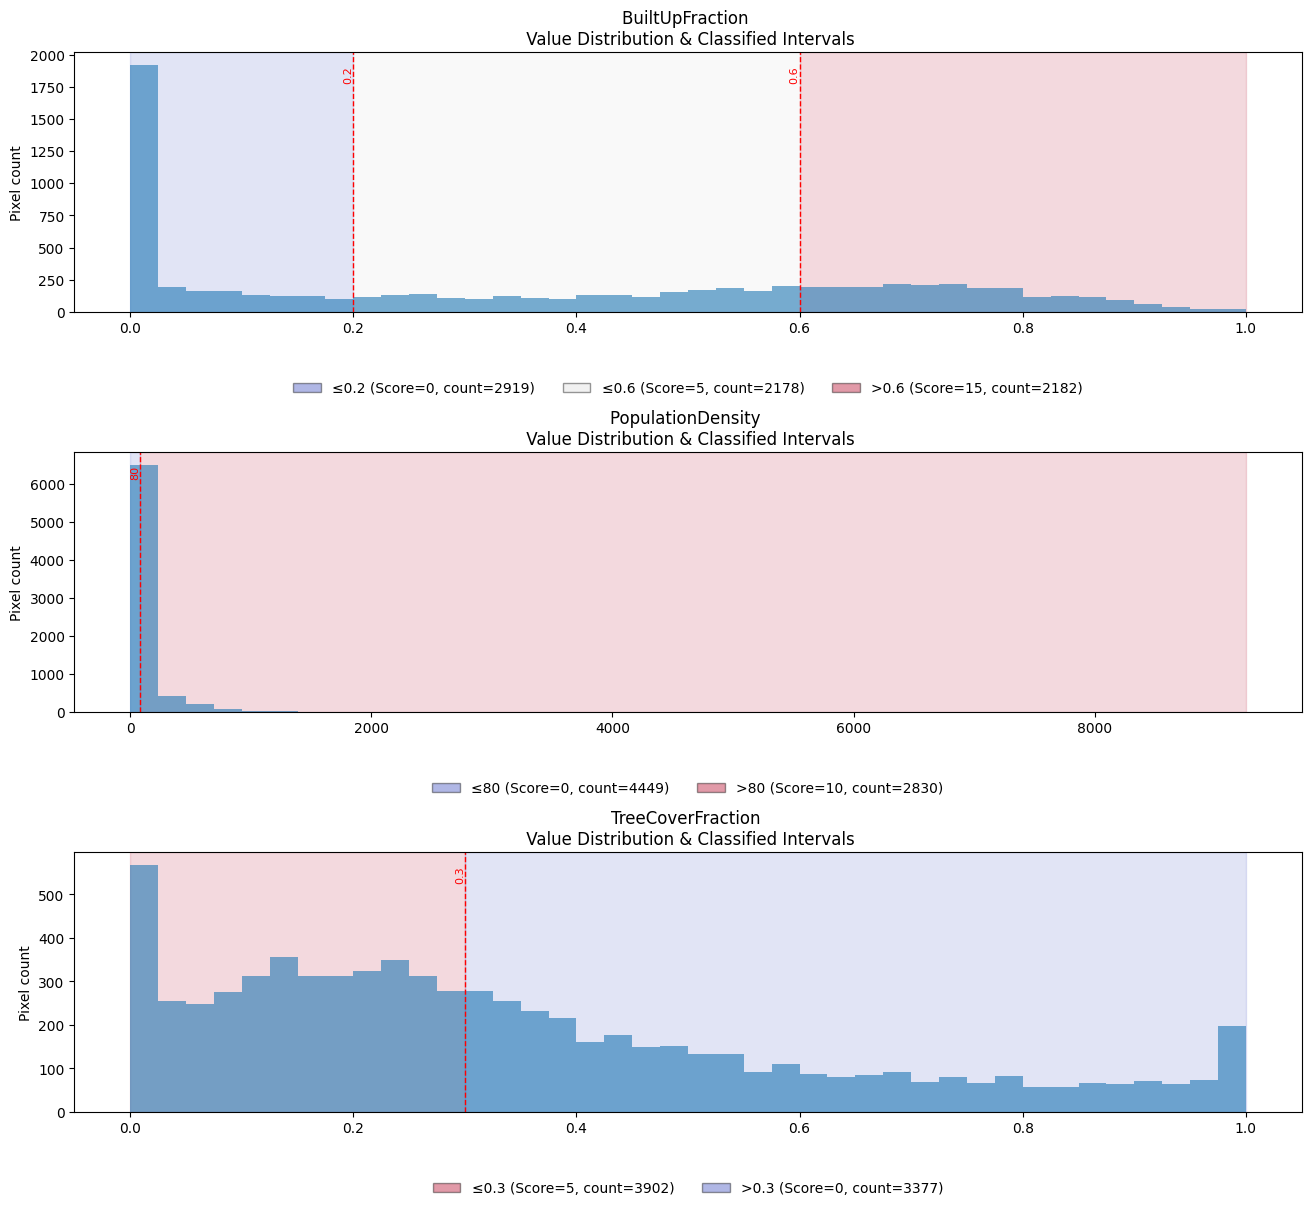

In [ ]:
# Specify bands used and their corresponding intervals and values

#change the proxy variable:
#add 'band' + 'intervals' + 'hotspot_score':

#band: is the band you want to use in your qualitative hotspot metric/map
#intervals: defines how you divide the 'band' into categories with a certain hotspot_score
#hotspot_score: the value you give to the certain interval: the higher the warmer

#see example code below for template:
#The bands BuiltUpFraction, PopulationDensity, and TreeCoverFraction are used
#Lets assume a certain pixel in the city has these characteristics with these resulting hotspot_scores:
#BuiltUpFraction=0.3 --> 5
#PopulationDensity=50 --> 0
#TreeCoverFraction=0.05 --> 5

#This means that if we sum the individual hotspot scores the pixel has a total hotspot score of 10!

scenario_name = "demo"
figname = os.path.join(FIGURE_FOLDER, f"Qualitative_mapping_{city}_{scenario_name}_proxy_bands_distribution.png")

proxy = [
    {
        'band': 'BuiltUpFraction',
        'intervals': [(0, 0.2), (0.2, 0.6), (0.6, 1)],
        'hotspot_score': [0, 5, 15]
    },
    {
        'band': 'PopulationDensity',
        'intervals': [(0, 80), (80, np.inf)],
        'hotspot_score': [0,  10]
    },
    {
        'band': 'TreeCoverFraction',
        'intervals': [(0, 0.3), (0.3, 1)],
        'hotspot_score': [5, 0]
    },
]



# Map band names to their corresponding band numbers (less important)
band_name_to_index = {name: i + 1 for i, name in enumerate(my_band_names)}
bands = [band_name_to_index[item['band']] for item in proxy]

# Prepare thresholds_list for downstream code compatibility (less important)
thresholds_list = [
    {'thresholds': [interval[1] for interval in item['intervals'][:-1]], 'hotspot_score': item['hotspot_score']}
    for item in proxy
]


#----------------------------------------------------------------------------------
plot_band_value_distributions(bands, thresholds_list, tif_file_path, band_names, figname)
#----------------------------------------------------------------------------------




## Take a look at your qualitative hotspot map

In [ ]:
hotspot_tif_path_hotspotmap=os.path.join(OUTPUTS_DIR, f'{scenario_name}_MAP.tif')

plot_hotspot_interactive(
    bands,
    thresholds_list,
    tif_file_path, #path of proxy data
    combine_method='sum',
    colormap_options=None,
    save_tif_path=hotspot_tif_path_hotspotmap
)



Successfully loaded GeoTIFF data from: /content/drive/MyDrive/ICUC12_Hackathon/Matthias/Davao/QUALITATIVE_MAPPING/demo_MAP.tif
File saved: True


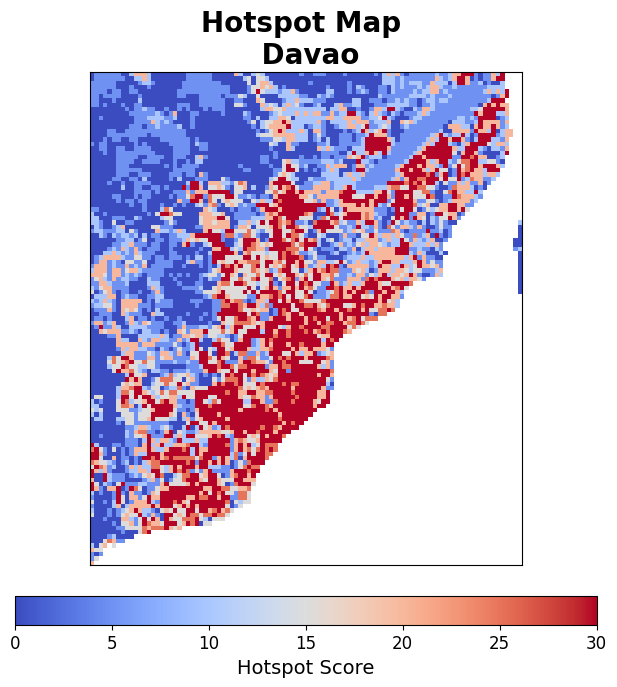

In [ ]:
#Save your map in the figures folder:

hotspot_tif_path_hotspotmap=hotspot_tif_path_hotspotmap=os.path.join(OUTPUTS_DIR, f'{scenario_name}_MAP.tif')
figname=figname = os.path.join(FIGURE_FOLDER, f"Qualitative_mapping_{city}_{scenario_name}_hotspot_map.png")
save_hotspot_figure(hotspot_tif_path_hotspotmap, figname, city, cmap='coolwarm')